# <b><u> Project Title : Traffic Jam: Predicting People's Movement into Nairobi </u></b>

## <b> Problem Description </b>

### This challenge asks you to build a model that predicts the number of seats that Mobiticket can expect to sell for each ride, i.e. for a specific route on a specific date and time. There are 14 routes in this dataset. All of the routes end in Nairobi and originate in towns to the North-West of Nairobi towards Lake Victoria.


### The towns from which these routes originate are:

* Awendo
* Homa Bay
* Kehancha
* Kendu Bay
* Keroka
* Keumbu
* Kijauri
* Kisii
* Mbita
* Migori
* Ndhiwa
* Nyachenge
* Oyugis
* Rodi
* Rongo
* Sirare
* Sori

### The routes from these 14 origins to the first stop in the outskirts of Nairobi takes approximately 8 to 9 hours from time of departure. From the first stop in the outskirts of Nairobi into the main bus terminal, where most passengers get off, in Central Business District, takes another 2 to 3 hours depending on traffic.

### The three stops that all these routes make in Nairobi (in order) are:

1. Kawangware: the first stop in the outskirts of Nairobi
2. Westlands
3. Afya Centre: the main bus terminal where most passengers disembark

### All of these points are mapped [here](https://www.google.com/maps/d/viewer?mid=1Ef2pFdP8keVHHid8bwju2raoRvjOGagN&ll=-0.8281897101491997%2C35.51706279999996&z=8).

### Passengers of these bus (or shuttle) rides are affected by Nairobi traffic not only during their ride into the city, but from there they must continue their journey to their final destination in Nairobi wherever that may be. Traffic can act as a deterrent for those who have the option to avoid buses that arrive in Nairobi during peak traffic hours. On the other hand, traffic may be an indication for people’s movement patterns, reflecting business hours, cultural events, political events, and holidays.

In [1]:
##importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset = pd.read_csv('/content/drive/MyDrive/AlmaBetter/Capstons Projects/Supervised ML (Regression) - Capstone Project/train_revised.csv')

In [5]:
dataset.head()

,ride_id,seat_number,payment_method,payment_receipt,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity
0,1442,15A,Mpesa,UZUEHCBUSO,17-10-17,7:15,Migori,Nairobi,Bus,49
1,5437,14A,Mpesa,TIHLBUSGTE,19-11-17,7:12,Migori,Nairobi,Bus,49
2,5710,8B,Mpesa,EQX8Q5G19O,26-11-17,7:05,Keroka,Nairobi,Bus,49
3,5777,19A,Mpesa,SGP18CL0ME,27-11-17,7:10,Homa Bay,Nairobi,Bus,49
4,5778,11A,Mpesa,BM97HFRGL9,27-11-17,7:12,Migori,Nairobi,Bus,49


In [6]:
#Shape
dataset.shape

(51645, 10)

Since the target Variable is not provided, So we should have to generate it.

In [7]:
num_of_seats = dataset.groupby(['ride_id'])['seat_number'].count()

In [8]:
num_of_seats = num_of_seats.reset_index().rename(columns= {'seat_number': 'number_of_tickets'})

In [9]:
dataset = dataset.merge(num_of_seats, how='left', on='ride_id')

In [10]:
dataset.shape

(51645, 11)

Now our Data has 11 columns

In [11]:
#getting some information about the variables
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51645 entries, 0 to 51644
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ride_id            51645 non-null  int64 
 1   seat_number        51645 non-null  object
 2   payment_method     51645 non-null  object
 3   payment_receipt    51645 non-null  object
 4   travel_date        51645 non-null  object
 5   travel_time        51645 non-null  object
 6   travel_from        51645 non-null  object
 7   travel_to          51645 non-null  object
 8   car_type           51645 non-null  object
 9   max_capacity       51645 non-null  int64 
 10  number_of_tickets  51645 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 4.7+ MB


In [12]:
dataset.isna().sum()

ride_id              0
seat_number          0
payment_method       0
payment_receipt      0
travel_date          0
travel_time          0
travel_from          0
travel_to            0
car_type             0
max_capacity         0
number_of_tickets    0
dtype: int64

I remove 'payment_receipt' to find to find duplicated values

In [13]:
dataset = dataset.drop('payment_receipt', axis=1)

In [14]:
dataset.duplicated().sum()

169

In [15]:
dataset = dataset.drop_duplicates()

Since there are No null and duplicate Observations

####**Feature Engineering**

---

I generate two new varibles travel_day, travel_month to identify the traveling time on the monthaly & daily basses.
And i also convert traveling time in hours to minutes.


*   After creating travel_month and travel_day i drop travel_date.




In [16]:
dataset['travel_month'] = dataset['travel_date'].apply(lambda x: pd.Timestamp(x).month_name())

In [17]:
dataset['travel_day'] = dataset['travel_date'].apply(lambda x: pd.Timestamp(x).day_name())

In [18]:
def hr_to_min(x):
  date = pd.Timestamp(x)
  hm = date.hour*60
  min = date.minute
  total_min = hm + min
  return total_min

In [19]:
dataset['travel_time'] = dataset['travel_time'].apply(lambda x: hr_to_min(x))

In [20]:
dataset = dataset.drop(['travel_date'], axis=1)

In [21]:
dataset.head()

,ride_id,seat_number,payment_method,travel_time,travel_from,travel_to,car_type,max_capacity,number_of_tickets,travel_month,travel_day
0,1442,15A,Mpesa,435,Migori,Nairobi,Bus,49,1,October,Tuesday
1,5437,14A,Mpesa,432,Migori,Nairobi,Bus,49,1,November,Sunday
2,5710,8B,Mpesa,425,Keroka,Nairobi,Bus,49,1,November,Sunday
3,5777,19A,Mpesa,430,Homa Bay,Nairobi,Bus,49,5,November,Monday
4,5778,11A,Mpesa,432,Migori,Nairobi,Bus,49,31,November,Monday


In [22]:
dataset['travel_time'] = dataset['travel_time'].apply(lambda x: 'Morning' if x < 720 else ('Afternoon' if x < 960 else 'Evening'))

#### description of the Data

In [23]:
dataset.describe(include='all')

,ride_id,seat_number,payment_method,travel_time,travel_from,travel_to,car_type,max_capacity,number_of_tickets,travel_month,travel_day
count,51476.000000,51476,51476,51476,51476,51476,51476,51476.000000,51476.000000,51476,51476
unique,NaN,61,2,2,17,1,2,NaN,NaN,12,7
top,NaN,1,Mpesa,Morning,Kisii,Nairobi,Bus,NaN,NaN,December,Wednesday
freq,NaN,2064,51364,46623,22587,51476,31835,NaN,NaN,9498,8233
mean,10187.614655,NaN,NaN,NaN,NaN,NaN,NaN,34.500855,17.274011,NaN,NaN
std,2211.273736,NaN,NaN,NaN,NaN,NaN,NaN,18.459386,12.380067,NaN,NaN
min,1442.000000,NaN,NaN,NaN,NaN,NaN,NaN,11.000000,1.000000,NaN,NaN
25%,8280.750000,NaN,NaN,NaN,NaN,NaN,NaN,11.000000,9.000000,NaN,NaN
50%,10352.000000,NaN,NaN,NaN,NaN,NaN,NaN,49.000000,11.000000,NaN,NaN
75%,12029.000000,NaN,NaN,NaN,NaN,NaN,NaN,49.000000,26.000000,NaN,NaN


####Examin the Data Distribution of target Variable

In [25]:
target_var = dataset['number_of_tickets']

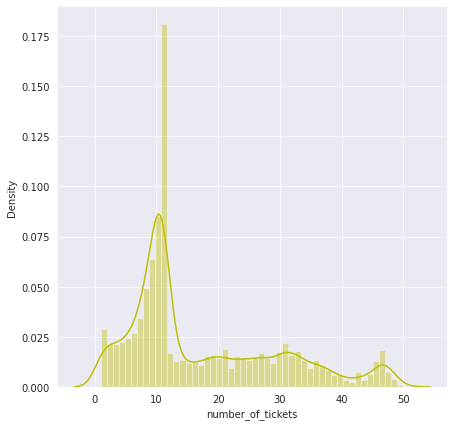

In [26]:
plt.figure(figsize=(7,7))
sns.distplot(target_var, color='y')
plt.show()

# Exploratory Data Analysis (EDA)

###First I perform EDA for **Numerical Variables**

In [27]:
numerical_feature = dataset.describe().columns
numerical_feature

Index(['ride_id', 'max_capacity', 'number_of_tickets'], dtype='object')

####Univariant Analysis

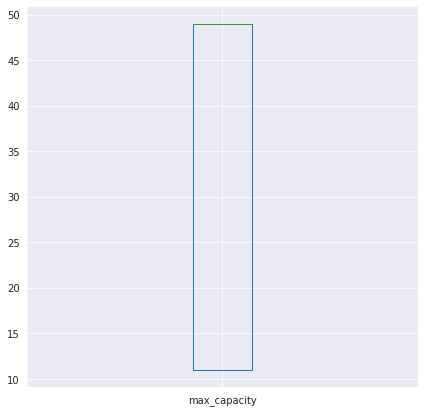

In [28]:
for col in numerical_feature[1:-1]:
  plt.figure(figsize=(7,7))
  dataset[col].plot(kind='box')
  

I draw a box plot of numerical variables to visualize the Outliers. Since there are no outliers.

Now I plot distplot of numerical Variables to see their data destribution.

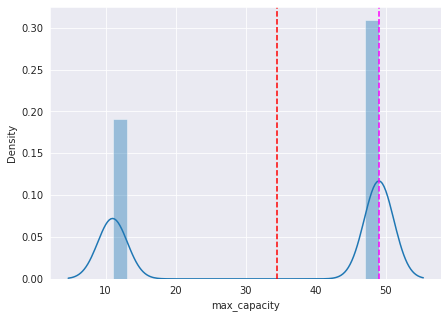

In [29]:
from pyparsing.helpers import LineStart
for col in numerical_feature[1:-1]:
  plt.figure(figsize = (7,5))
  sns.distplot(dataset[col])
  mean = dataset[col].mean()
  median = dataset[col].median()
  plt.axvline(mean, linestyle='--', color='red')
  plt.axvline(median, linestyle='--', color='magenta')

In [30]:
dataset['max_capacity'].unique()

array([49, 11])

since 'max_capacity' feature has only two unique values therefore we can consider it as a catagotical feature. 

###EDA For **Categorical Variabels**

In [31]:
categorical_features = dataset.describe(include = ['object', 'category']).columns
categorical_features = np.append(categorical_features, ['max_capacity'], axis=0)
categorical_features = np.delete(categorical_features, 2)
categorical_features

array(['seat_number', 'payment_method', 'travel_from', 'travel_to',
       'car_type', 'travel_month', 'travel_day', 'max_capacity'],
      dtype=object)

####Univarient Analysis

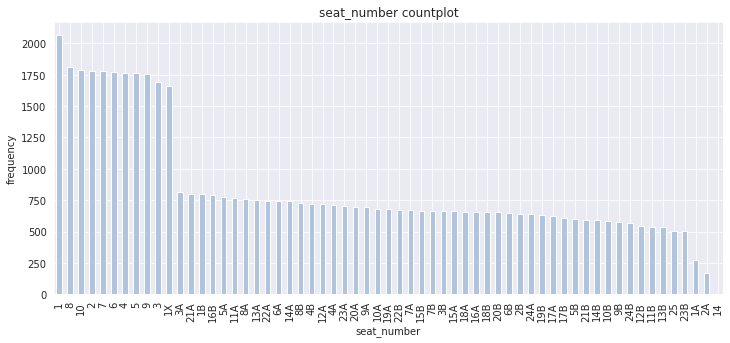

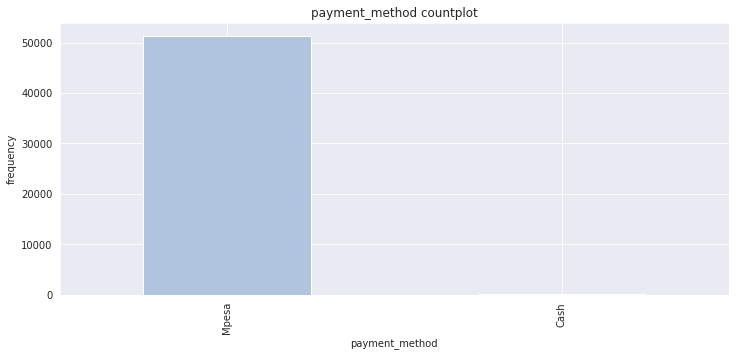

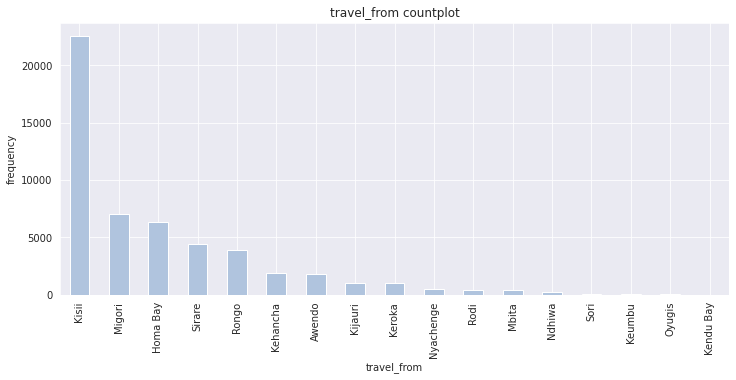

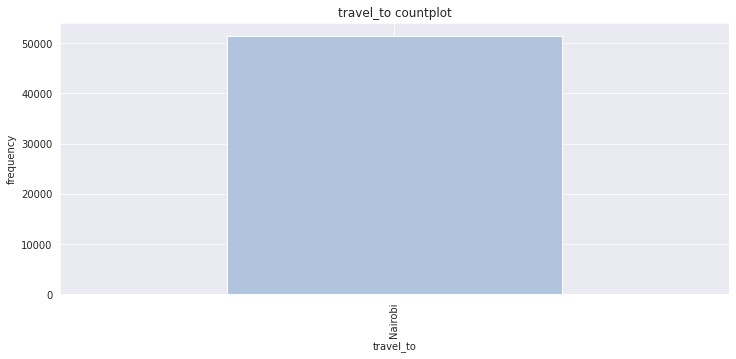

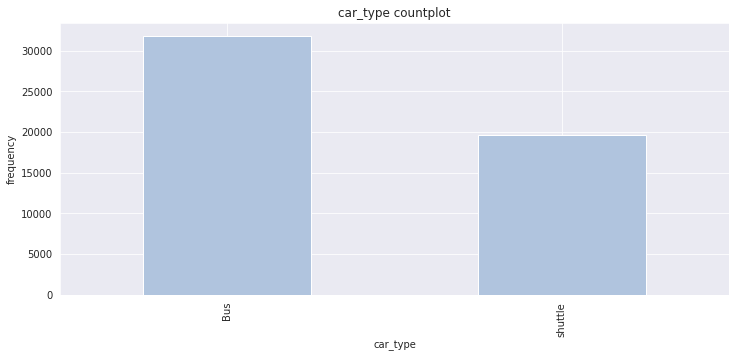

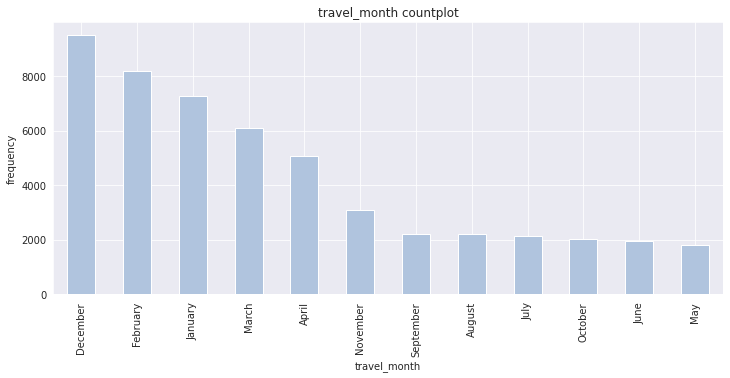

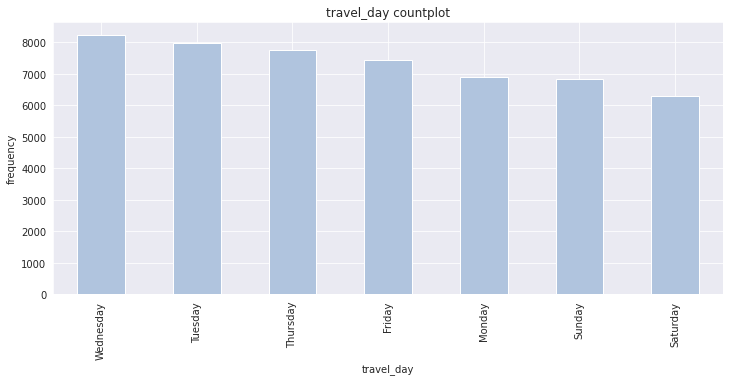

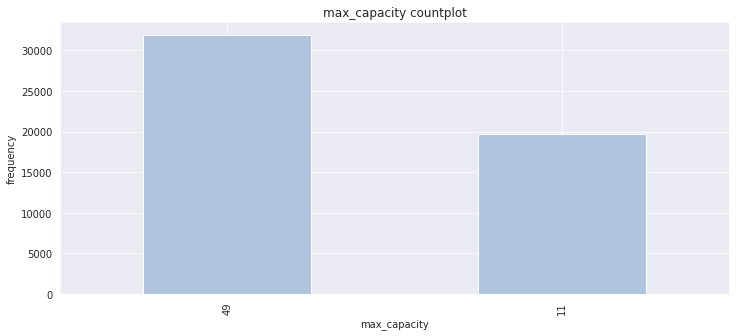

In [32]:
for col in categorical_features:
  count = dataset[col].value_counts()
  plt.figure(figsize = (12,5))
  count.plot(kind='bar', color='lightsteelblue')
  plt.xlabel(col)
  plt.ylabel('frequency')
  plt.title(f'{col} countplot')

plt.show()

from the above plots i comes to some conclusions:-


*   The route originat from kisii town has more movement as compare to other towns.

*   Movement of peoples are linear from May to september. and increase in the months from December to April
* The vehicle having 49 seats capacity are more in use as compare to vehicle having 11 seat capacity

* there is no ride is happining and the movment of peoples are more at morning as compaire Evening.


### Bivarient Analysis

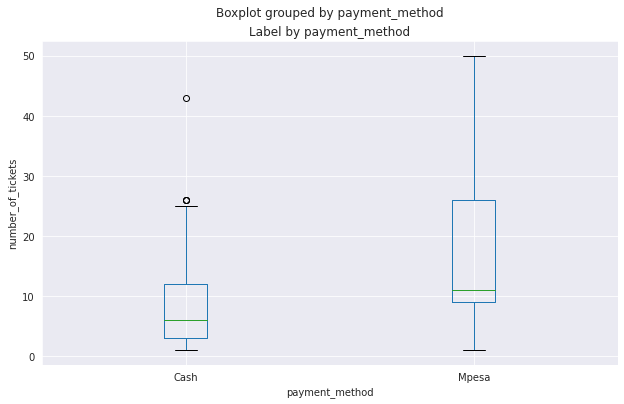

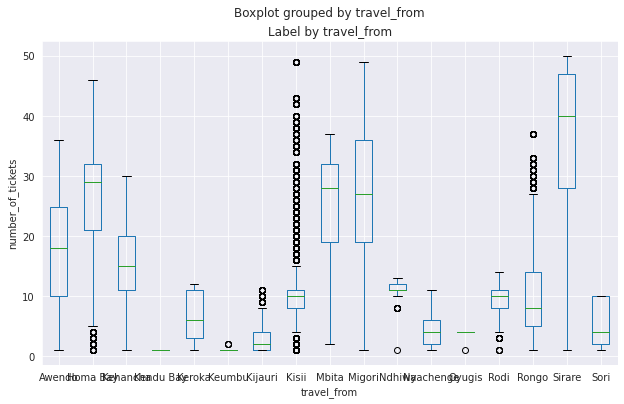

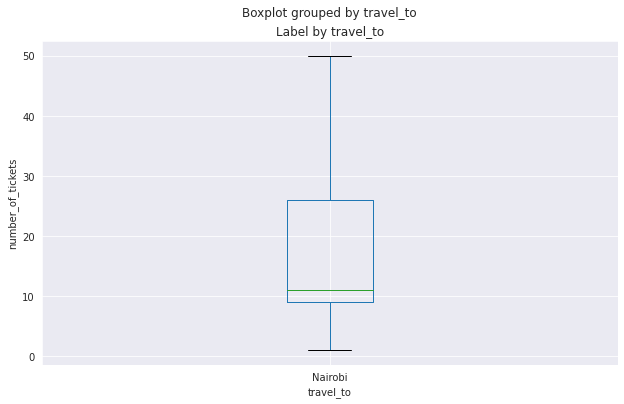

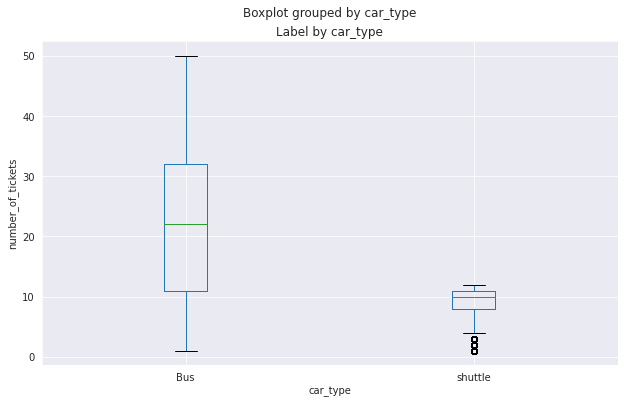

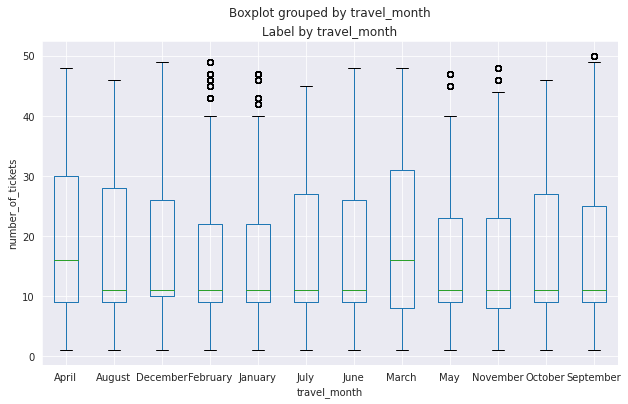

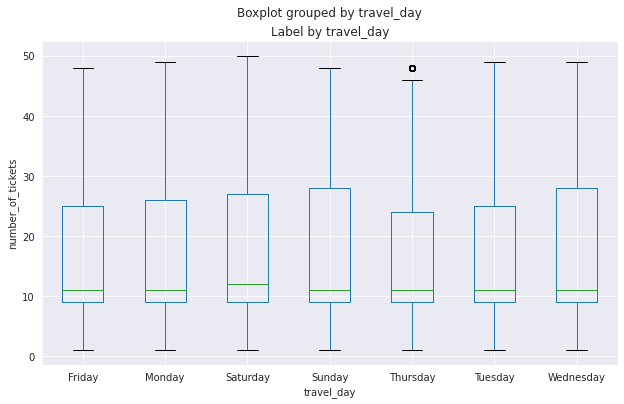

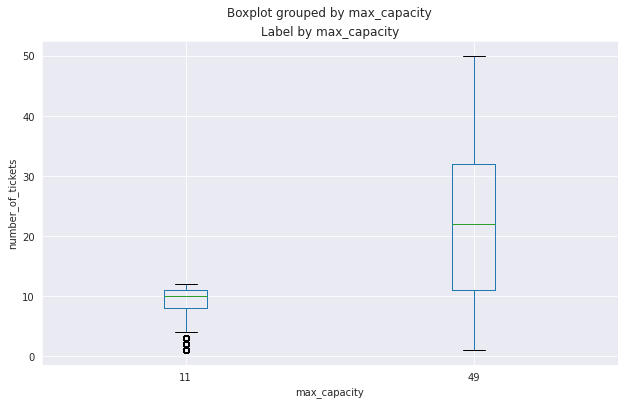

In [34]:
for col in categorical_features[1:]:
  fig = plt.figure(figsize = (10,6))
  ax = fig.gca()
  dataset.boxplot(column = 'number_of_tickets', by=col, ax = ax)
  ax.set_title('Label by ' + col)
  ax.set_ylabel('number_of_tickets')

plt.show()

what i get from above plots :-


*   More tickets are booked through Mpesa Payment Method.
*   tickets of buses are more booked as compaire shuttle.
* In March & April months more tickets are booked as compaire to other months.
* Booking of tickets are linear in all days of the weeks.
* As natural more capacity have more seats for booking, therefore 49 seats capacity vehicle have more booking as compare less capacity vehicle.
* Above we see that on bar plot the Morning Strength is more as compair to Evening but on box plot the number of tickets are more in Evening.
I thing it is becouse at morning time some peoples use train to reach their places on time. 




# Feature Engineering

In [35]:
df = dataset.copy()

In [36]:
#label encoding
encoding = {
    'payment_method' : {'Cash' : 0, 'Mpesa' : 1}, 
    'car_type': {'Bus': 0, 'shuttle' : 1},
    'travel_time': {'Morning' : 1, 'Evening': 0},
    'max_capacity' : {11 : 0, 49: 1}
}

df = df.replace(encoding)

In [37]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 751 kB/s 


In [38]:
import category_encoders as ce

encoder = ce.BinaryEncoder(cols= ['travel_from', 'travel_month', 'travel_day'], return_df= True)


In [39]:
df = encoder.fit_transform(df)

In [40]:
df.head()

,ride_id,seat_number,payment_method,travel_time,travel_from_0,travel_from_1,travel_from_2,travel_from_3,travel_from_4,travel_to,car_type,max_capacity,number_of_tickets,travel_month_0,travel_month_1,travel_month_2,travel_month_3,travel_day_0,travel_day_1,travel_day_2
0,1442,15A,1,1,0,0,0,0,1,Nairobi,0,1,1,0,0,0,1,0,0,1
1,5437,14A,1,1,0,0,0,0,1,Nairobi,0,1,1,0,0,1,0,0,1,0
2,5710,8B,1,1,0,0,0,1,0,Nairobi,0,1,1,0,0,1,0,0,1,0
3,5777,19A,1,1,0,0,0,1,1,Nairobi,0,1,5,0,0,1,0,0,1,1
4,5778,11A,1,1,0,0,0,0,1,Nairobi,0,1,31,0,0,1,0,0,1,1


**final features**

In [41]:
features_ = df.describe().columns
features_ = np.delete(features_, 0)
features_

Index(['payment_method', 'travel_time', 'travel_from_0', 'travel_from_1',
       'travel_from_2', 'travel_from_3', 'travel_from_4', 'car_type',
       'max_capacity', 'number_of_tickets', 'travel_month_0', 'travel_month_1',
       'travel_month_2', 'travel_month_3', 'travel_day_0', 'travel_day_1',
       'travel_day_2'],
      dtype='object')

In [42]:
df_pr = df[features_]

In [43]:
X = df_pr[np.delete(features_, 9) ]
Y = df_pr['number_of_tickets']